<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/copilotiatrainer_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow==2.13.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# cd change directory?

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

Define the Autoencoder architecture

In [ ]:
input_img = tf.keras.Input(shape=(224, 224, 3))

Encoder

In [ ]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

Decoder

In [ ]:
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

Compile the Autoencoder with mean squared error loss

In [ ]:
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Prepare the dataset with data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest'
    )

Custom data generator that yields both input and target data

In [ ]:
def custom_data_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/datasets/train',
    target_size=(224, 224),
    batch_size=15,
    class_mode=None,  # No labels needed
    subset='training'
)

Found 1500 images belonging to 1 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/datasets/validation',
    target_size=(224, 224),
    batch_size=15,
    class_mode=None,  # No labels needed
    subset='validation'
)

Found 1500 images belonging to 1 classes.


Train the Autoencoder

In [ ]:

history = autoencoder.fit(
    custom_data_generator(train_generator),
    epochs=150,
    validation_data=custom_data_generator(validation_generator),
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)]
)


1500/1500 [==============================] - 1206s 803ms/step - loss: 0.0020 - val_loss: 4.5308e-04


Save the Autoencoder model

In [ ]:
autoencoder.save('anomaly_autoencoder_model.h5')
autoencoder.save_weights('anomaly_autoencoder_weights.weights.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 235ms/step


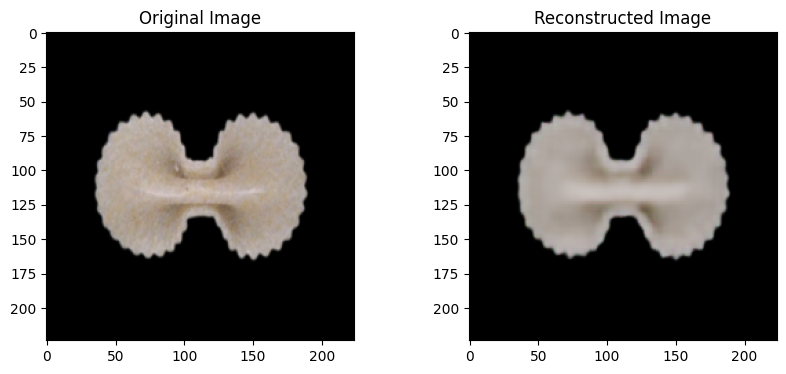

Anomaly detected in 0012.png
Reconstruction error for 0012.png: 0.0005131440702825785
1/1 [==============================] - 0s 75ms/step


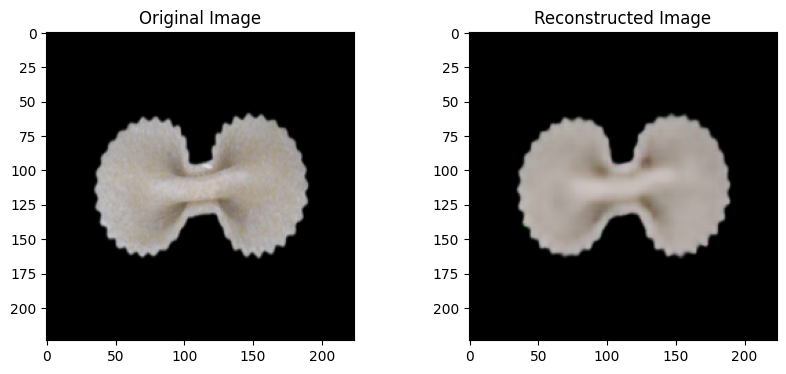

Anomaly detected in 0153.png
Reconstruction error for 0153.png: 0.00043955608271062374
1/1 [==============================] - 0s 73ms/step


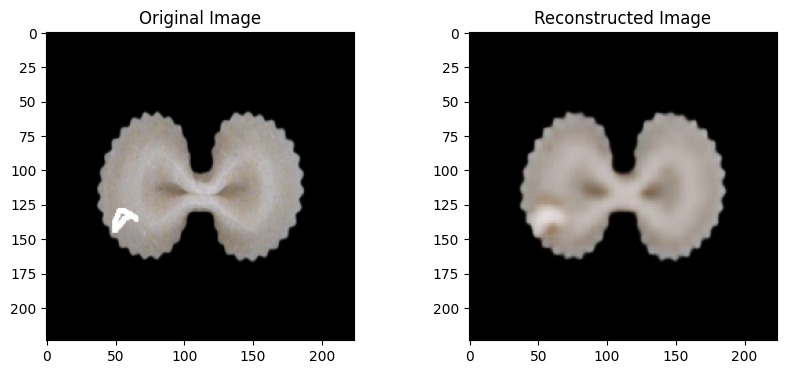

Anomaly detected in 0001.png
Reconstruction error for 0001.png: 0.0005311890272423625
1/1 [==============================] - 0s 72ms/step


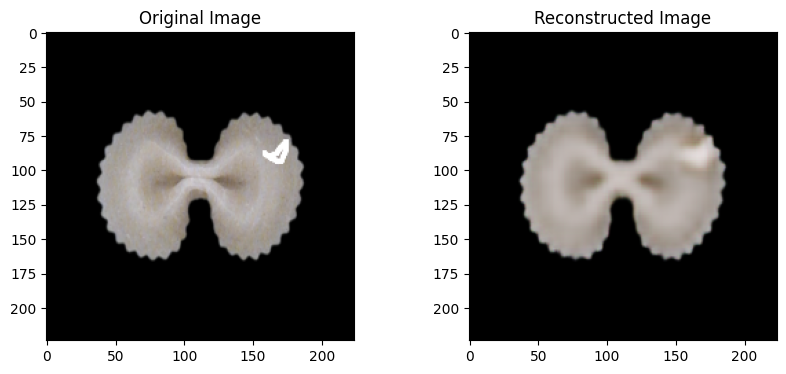

Anomaly detected in 0000.png
Reconstruction error for 0000.png: 0.0005329821142368019
1/1 [==============================] - 0s 88ms/step


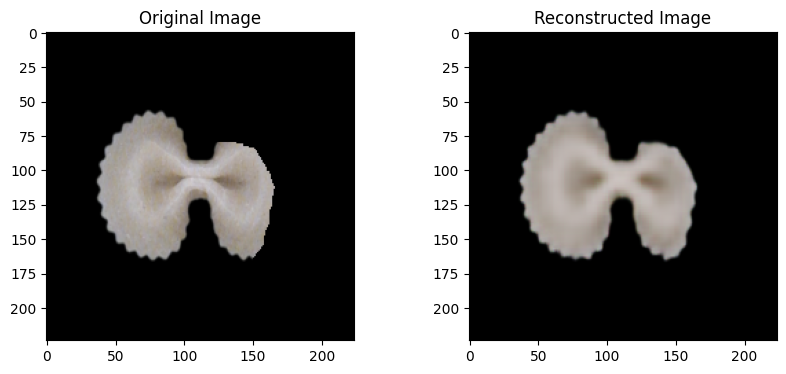

Anomaly detected in 0002.png
Reconstruction error for 0002.png: 0.00046670142910443246
1/1 [==============================] - 0s 78ms/step


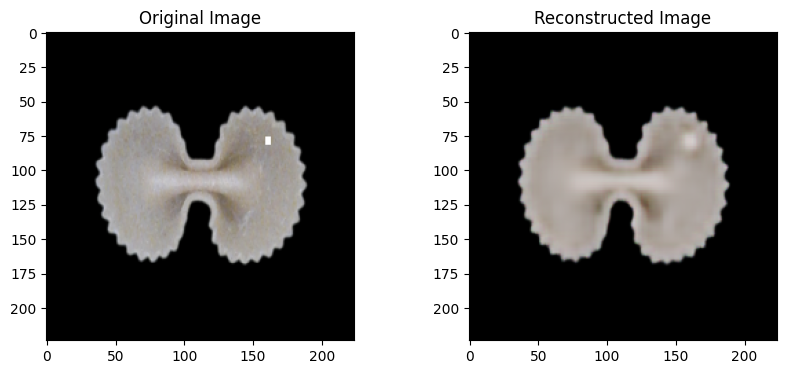

Anomaly detected in 0003.png
Reconstruction error for 0003.png: 0.0005851524765603244


In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
threshold = 0.000161

# Load the trained Autoencoder model
#autoencoder = tf.keras.models.load_model('anomaly_autoencoder_model.h5')
#autoencoder.save_weights('anomaly_autoencoder_weights.weights.h5')

# Function to preprocess the image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img_array

# Function to compute reconstruction error and visualize reconstruction
def compute_reconstruction_error(model, img):
    reconstructed_img = model.predict(np.expand_dims(img, axis=0))
    error = np.mean((img - reconstructed_img[0]) ** 2)

    # Visualize the original and reconstructed images
    plt.figure(figsize=(10, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_img[0])

    plt.show()

    return error

# Path to the folder containing images
folder_path = "/content/drive/MyDrive/malas"

# Loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img_path = os.path.join(folder_path, filename)

        # Preprocess the image
        img_array = preprocess_image(img_path)

        # Compute the reconstruction error
        error = compute_reconstruction_error(autoencoder, img_array)

        # Interpret the reconstruction error
        if error > threshold:
            print(f"Anomaly detected in {filename}")
        else:
            print(f"{filename} is Normal")

        # Print the reconstruction error
        print(f"Reconstruction error for {filename}: {error}")